In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt

import pysindy as ps

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"data//"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
# change data set
DATA = SILVER
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

# drop nan's may need to be adjusted between data sets
mask = ~np.isnan(data)
data = data[mask[:,0],:]
data = data[:,:-1]

system_data = System_data(u=data[:,0],y=data[:,1])
train, test = system_data[40000:], system_data[:40000]

In [3]:
# load trained ss encoder
fit_sys_ss_enc = deepSI.load_system('models/silverbox_50_2')

In [4]:
test_sim_enc = fit_sys_ss_enc.apply_experiment(test, save_state=True)

# plt.plot(test.y)
# plt.plot(test.y - test_sim_enc.y)
# plt.title(f'test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test):.2%}')
# plt.show()

train_sim_enc = fit_sys_ss_enc.apply_experiment(train, save_state=True)

In [5]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

def center(y):
    return y-np.mean(y)

In [6]:
library_functions = [
        lambda x: 1,
        lambda x: x,
        lambda x: x**2,
        lambda x: x**3,
]

library_function_names = [
    lambda x: "1",
    lambda x: x,
    lambda x: x+"^2",
    lambda x: x+"^3",
]

custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

In [7]:
differentiation_method = ps.FiniteDifference(order=4)

x_train = np.c_[train_sim_enc.x, train.y]

# model specs
feature_library = ps.ConcatLibrary([ ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(alpha=0, threshold= 0.1, verbose=True)#alpha=2, threshold= 0.1, 

model = ps.SINDy(feature_library=custom_library,
                 optimizer=stlsq_optimizer,
                 discrete_time = True
                 )

# fit
model.fit(x_train, u=train.u)
model.print()
model.coefficients()

x_test = np.c_[test_sim_enc.x, test.y]

x_dot_test_predicted = model.predict(x_test, u=test.u)
x_dot_test_simulated = model.simulate(x_test[0], u=test.u[:], t=test.u.shape[0])

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.8892e+01 ... 0.0000e+00 ...         30 ... 3.8892e+01
         1 ... 1.2116e+02 ... 0.0000e+00 ...         29 ... 1.2116e+02
         2 ... 1.2121e+02 ... 0.0000e+00 ...         29 ... 1.2121e+02
(x0)[k+1] = -34216744233.541 1 + 11408019033.432 1 + 11407616425.765 1 + 11401108774.455 1 + 0.318 x0[k] + -0.701 x1[k] + 2.995 u0[k] + 0.183 x2[k]^2 + 8.236 u0[k]^3
(x1)[k+1] = 128898903418.795 1 + -43003294003.898 1 + -42882826700.025 1 + -43012782714.840 1 + 0.554 x0[k] + 1.006 x1[k] + 1.007 x2[k] + -2.551 u0[k] + 0.302 x2[k]^2 + -0.404 u0[k]^2 + 7.282 u0[k]^3
(x2)[k+1] = 14756275307.437 1 + -4920970823.601 1 + -4917614530.522 1 + -4917689953.289 1 + -0.127 x1[k] + 0.736 x2[k] + 0.430 u0[k] + 0.255 x2[k]^3 + 0.790 u0[k]^3


In [23]:
y = center(test.y)

x1 = center(test_sim_enc.x[:,0].flatten())
x2 = center(test_sim_enc.x[:,1].flatten())

pred_NRMS = NRMS( center(x_dot_test_predicted[:-1,0]), x1[1:])
simo_NRMS = NRMS( center(x_dot_test_simulated[:,0]), x1)

print("x1 NRMS pred: ",pred_NRMS)
print("x1 NRMS simo: ",simo_NRMS)

pred_NRMS = NRMS( center(x_dot_test_predicted[:-1,1]), x2[1:])
simo_NRMS = NRMS( center(x_dot_test_simulated[:,1]), x2)

print("x2 NRMS pred: ",pred_NRMS)
print("x2 NRMS simo: ",simo_NRMS)

pred_NRMS = NRMS( center(x_dot_test_predicted[:-1,2]), y[1:])
simo_NRMS = NRMS( center(x_dot_test_simulated[:,2]), y)

print("y NRMS pred: ",pred_NRMS)
print("y NRMS simo: ",simo_NRMS)

x1 NRMS pred:  0.012775254227219767
x1 NRMS simo:  0.2607881385029116
x2 NRMS pred:  0.038361613017406815
x2 NRMS simo:  0.28614224869947535
y NRMS pred:  0.031063187254770253
y NRMS simo:  0.2820400887537754


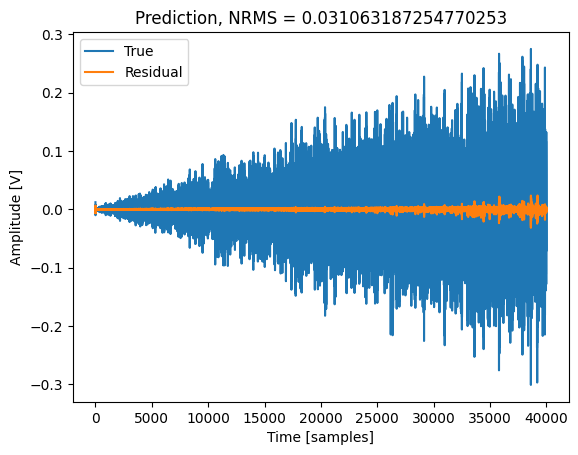

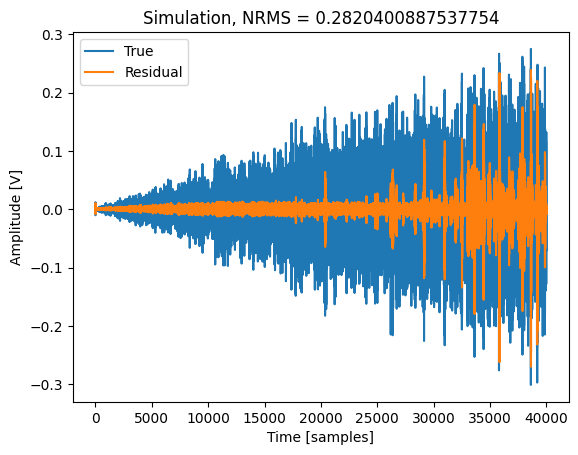

In [39]:
plt.plot(y[1:])
plt.plot(center(x_dot_test_predicted[:-1,2])-y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(y)
plt.plot(center(x_dot_test_simulated[:,2])-y[:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Simulation, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

In [9]:
# differentiation_method = ps.FiniteDifference(order=4)

# x_train = train.y
# u_train = train_sim_enc.x

# # model specs
# feature_library = ps.ConcatLibrary([ ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

# stlsq_optimizer = ps.STLSQ( verbose=True)#alpha=2, threshold= 0.1, 

# model = ps.SINDy(feature_library=custom_library,
#                  optimizer=stlsq_optimizer,
#                  discrete_time = True
#                  )

# # fit
# model.fit(x_train, u=u_train)
# model.print()
# model.coefficients()

# x_test = test.y
# u_test = test_sim_enc.x

# x_dot_test_predicted = model.predict(x_test, u=u_test)
# x_dot_test_simulated = model.simulate(x_test[0], u=u_test[:], t=u_test.shape[0])#

In [10]:
# y = center(test.y)

# x_dot_test_predicted = center(x_dot_test_predicted.flatten())
# x_dot_test_simulated = center(x_dot_test_simulated.flatten())

# pred_NRMS = NRMS( x_dot_test_predicted[:-1], y[1:])
# simo_NRMS = NRMS( x_dot_test_simulated[:], y)

# print("x1 NRMS pred: ",pred_NRMS)
# print("x1 NRMS simo: ",simo_NRMS)


In [11]:
# plt.plot(y[1:])
# plt.plot(x_dot_test_predicted[:-1]-y[1:])
# plt.ylabel("Amplitude [V]")
# plt.xlabel("Time [samples]")
# plt.title("Prediction, NRMS = "+str(pred_NRMS))
# plt.legend(["True","Residual"])
# plt.show()

# plt.plot(y)
# plt.plot(x_dot_test_simulated[:]-y[:])
# plt.ylabel("Amplitude [V]")
# plt.xlabel("Time [samples]")
# plt.title("Simulation, NRMS = "+str(simo_NRMS))
# plt.legend(["True","Residual"])
# plt.show()